In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from corpy.get_data.get_data import data_download

data_download()

Downloading...
From: https://drive.google.com/u/0/uc?id=11ozVs6zByFjs9viD3VIIP6qKFgjZwv9E&export=download
To: /home/roger/code/xkeeja/corpy-assessment/screws.zip
100%|██████████| 195M/195M [00:07<00:00, 27.3MB/s] 


Unzipping file...
Data successfully unzipped to data/archive.
Deleting zip file...
Deleted zip file.


In [2]:
from corpy.ml_logic.data import load_data

batch_size = 32
img_size = 128

ds_train = load_data(batch_size, img_size, 'train')
ds_test = load_data(batch_size, img_size, 'test')
ds_anom = load_data(batch_size, img_size, 'anomaly_only')

2022-12-21 20:46:30.239173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 20:46:30.369725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-21 20:46:30.369748: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-21 20:46:31.216188: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

Found 250 files belonging to 1 classes.


2022-12-21 20:46:32.417084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-21 20:46:32.417105: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-21 20:46:32.417122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-12-21 20:46:32.417384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 180 files belonging to 1 classes.
Found 50 files belonging to 1 classes.


In [35]:
from corpy.ml_logic.model import create_encoder, create_decoder

latent_dim = 128

encoder, shape = create_encoder(img_size, latent_dim)
decoder = create_decoder(shape, latent_dim)

In [36]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization_18 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        9248

In [37]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_7 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_3 (Reshape)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 32, 32, 64)       18496     
 Transpose)                                                      
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 64, 64, 32)       1846

In [38]:
import tensorflow.keras as keras
from corpy.ml_logic.model import AE_mse

rop = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,patience=10, min_lr=0.00001,cooldown=100,verbose=1)

ae_mse = AE_mse(encoder, decoder)
ae_mse.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [39]:
ae_mse.build(input_shape=(None,128,128,3))
ae_mse.load_weights('trained/mse/ae_mse_weights(1).h5')

<AxesSubplot: >

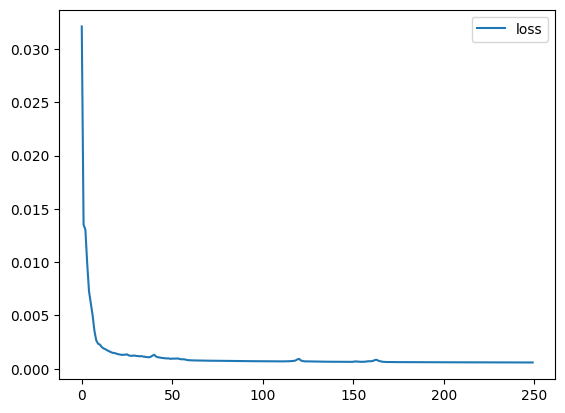

In [40]:
import pandas as pd

mse_history = pd.read_csv('trained/mse/ae_mse_history(1).csv')
mse_history.loc[:, ['loss']].plot()

In [41]:
from corpy.ml_logic.model import AE_bce

ae_bce = AE_bce(encoder, decoder)
ae_bce.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [42]:
ae_bce.build(input_shape=(None,128,128,3))
ae_bce.load_weights('trained/bce/ae_bce_weights.h5')

<AxesSubplot: >

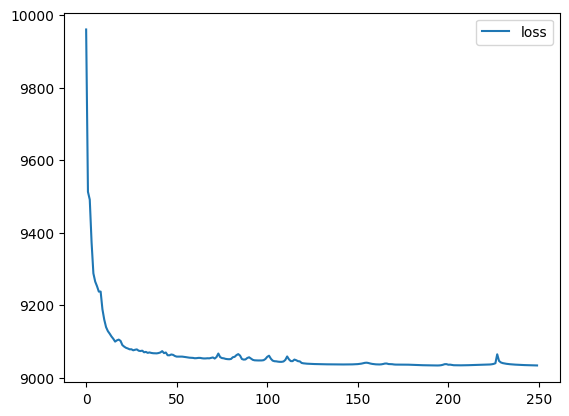

In [43]:
bce_history = pd.read_csv('trained/bce/ae_bce_history.csv')
bce_history.loc[:, ['loss']].plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO] mse threshold: 0.0014923718641512097
[INFO] 4 outliers found


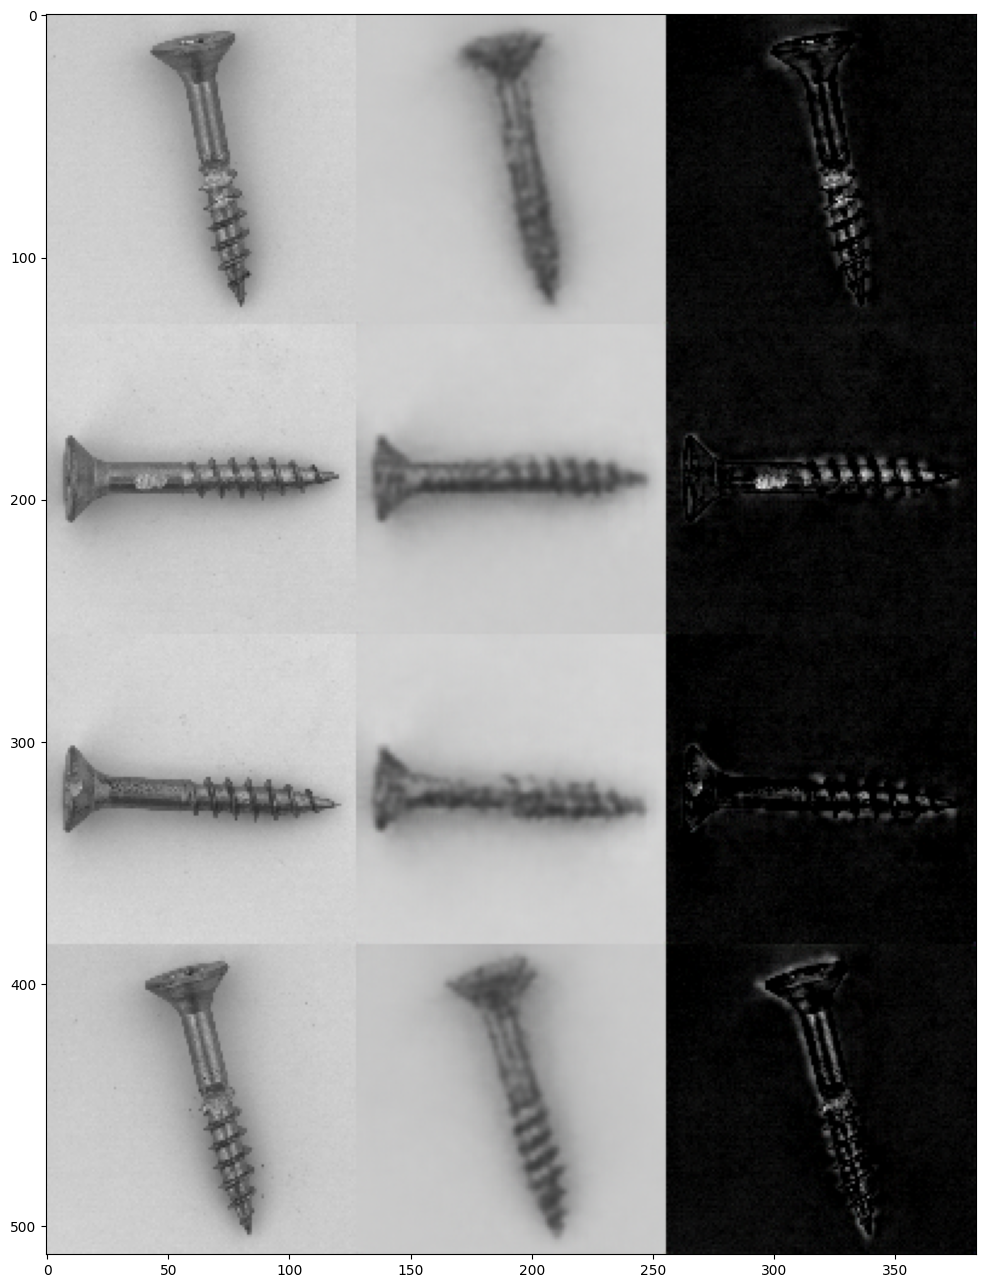

In [44]:
import matplotlib.pyplot as plt
import numpy as np

imgs = list(ds_anom)[0]
# make predictions on our image data and initialize our list of
# reconstruction errors
_, recon = ae_mse(imgs)
errors = []

# loop over all original images and their corresponding
# reconstructions
for (image, rec) in zip(imgs, list(recon)):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - rec) ** 2)
	errors.append(mse)

# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.90)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

# initialize the outputs array
outputs = None

# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = imgs[i]
	rec = list(recon)[i]
	diff = (original - rec) * 2
	

    # stack the original and reconstructed image side-by-side
	output = np.hstack([original, rec, diff])

    # if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

    # otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# show the output visualization
plt.figure(figsize=(12, 20))
plt.imshow(outputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO] mse threshold: 0.0014923718641512097
[INFO] 4 outliers found


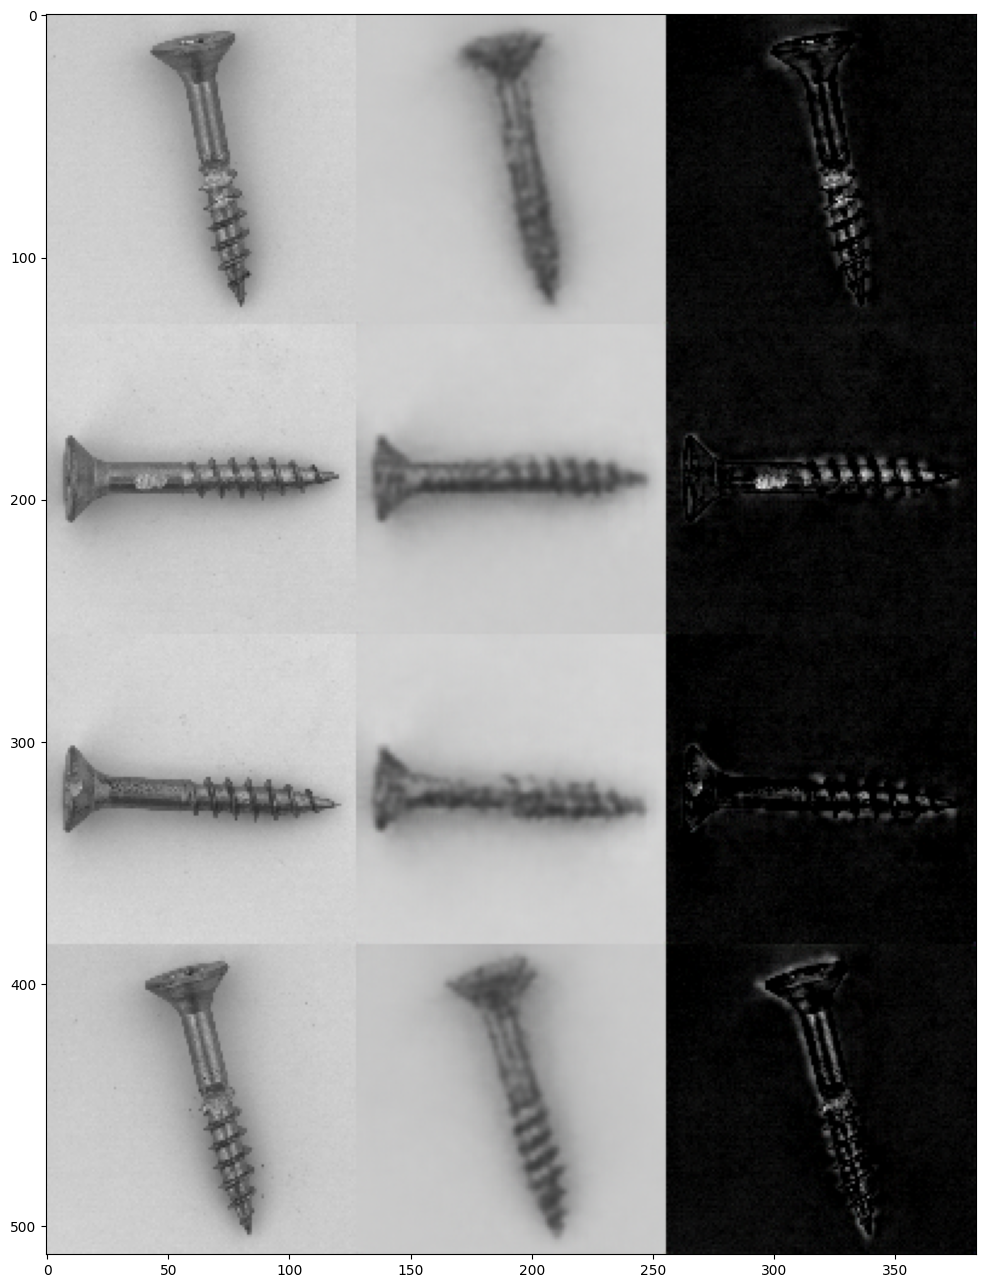

In [45]:
import matplotlib.pyplot as plt
import numpy as np

imgs = list(ds_anom)[0]
# make predictions on our image data and initialize our list of
# reconstruction errors
_, recon = ae_bce(imgs)
errors = []

# loop over all original images and their corresponding
# reconstructions
for (image, rec) in zip(imgs, list(recon)):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - rec) ** 2)
	errors.append(mse)

# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.90)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

# initialize the outputs array
outputs = None

# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = imgs[i]
	rec = list(recon)[i]
	diff = (original - rec) * 2
	

    # stack the original and reconstructed image side-by-side
	output = np.hstack([original, rec, diff])

    # if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

    # otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# show the output visualization
plt.figure(figsize=(12, 20))
plt.imshow(outputs)